# Medical Misinformation Dataset

In order to create a medical misinformation dataset of news articles/blogs and claims debunked by means of fact-checking articles (and to continuously obtain new data), we used our research platform MonAnt (Srba et al., Monant: universal and extensible platform for monitoring, detection and mitigation of antisocial behaviour. In: Workshop on Reducing Online Misinformation Exposure–ROME, 2019). The MonAnt platform provides so called data providers to extract news articles/blogs from news/blog sites as well as fact-checking articles from fact-checking sites. General parsers (from RSS feeds, Wordpress sites, Google Fact Check Tool, etc.) as well as custom crawler and parsers were implemented (e.g., for fact checking site Snopes.com). All data is stored in the unified format in a central data storage.

The guide providing instructions how to read/write data from Monant platform is available at: https://kinit.sk/research/medical-misinformation-dataset

API documentation is available at: https://api.monant.kinit.sk/apidocs

## Credentials

Currently, the access to dataset can be provided by sending a request to ivan.srba@kinit.sk.

Set to your credentials

In [ ]:
username_my = 'username'
password_my = 'password'

Set if a specific time range of the data is needed (set time_freeze_on to value of True) and the time range (from, to) in the format of YYYY-MM-DD

In order to make the analysis replicable, it uses a ”freeze time” (currently set to August 4, 2021).  A sa result, only those data that were present in the MonAnt platform up to this date are considered.

In [2]:
time_freeze_on = True
time_freeze_from = '1990-01-01'
time_freeze_to = '2021-08-04'

## Initialization

In [3]:
%matplotlib inline

import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Set API base URL

In [4]:
API_URL = 'https://api.monant.kinit.sk/'

Set version of API

In [5]:
API_URL_v = 'v1/'

## API

In [6]:
import requests

### Get access token

In [7]:
def get_access_token():
    """
    Get access token
    """
    pload = {'username': username_my, 'password': password_my}
    r = requests.post(API_URL + 'auth', json = pload)
    access_token = r.json()['access_token']
    
    return(access_token)

### Get data functions

In [8]:
api_batch_size = 100

In [9]:
def get_data(request_URL, request_params):
    """
    Get data by get
    """
    if time_freeze_on:
        if request_URL in ['articles', 'fact-checking-articles', 'discussions', 'discussion-posts']:
            request_params['from'] = time_freeze_from
            request_params['to'] = time_freeze_to
            
        if request_URL in ['claims', 'sources', 'relation-annotations', 'relation-annotations']:
            request_params['created_from'] = time_freeze_from
            request_params['created_to'] = time_freeze_to
    
    return(requests.get(
            API_URL + API_URL_v + request_URL,
            params=request_params,
            headers={"Content-Type": "application/json", "Authorization": f"JWT {access_token}"}
        ))

In [10]:
def get_entity_df(entity, request_params):
    """
    Get data by get to dataframe
    """
    request_params['size'] = 1
    pages_n = (get_data(entity, request_params).json()['pagination']['pages'] // api_batch_size) + 1
    entity_key = entity_to_entity_key(entity)
    data_json = []
    request_params['size'] = api_batch_size
    
    for page in range(1, pages_n + 1):
        request_params['page'] = page
        data_json_batch = json.loads(json.dumps(get_data(entity, request_params).json()[entity_key]))
        data_json = data_json + data_json_batch

    df_batch = pd.json_normalize(data_json)
    return df_batch

In [11]:
def entity_to_entity_key(entity):
    entity_key = re.sub('-', '_', entity)
    return entity_key

### Init

Obtain a Monant API access token with a lifespan of several hours. Subsequently, a new one must be requested.

In [12]:
access_token = get_access_token()

# 3.2 Descriptive Analysis of Raw Data

MonAnt had collected in total:

In [47]:
n_articles = 0

for entity in ['articles', 'sources', 'fact-checking-articles', 'claims', 'relation-annotations', 'discussion-posts',  'discussions']:
    print('Number of ' + str(entity) + ': ' + str(get_data(entity, {'size': 1}).json()['pagination']['total']))
    
    if entity == 'sources':
        print('Average number of articles per source: ' + str(round(n_articles / get_data(entity, {'size': 1}).json()['pagination']['total'], 2)))
    if entity == 'articles':
        n_articles = get_data(entity, {'size': 1}).json()['pagination']['total']

Number of articles: 827781
Number of sources: 241
Average number of articles per source: 3434.78
Number of fact-checking-articles: 7984
Number of claims: 8866
Number of relation-annotations: 684942
Number of discussion-posts: 752081
Number of discussions: 45108


In [14]:
entity = 'sources'
for reliability in ['reliable', 'unreliable', 'unknown']:
    print('Number of ' + str(reliability) + ' ' + str(entity) + ': ' + str(get_data(entity, {'size': 1, 'veracity': reliability}).json()['pagination']['total']))

Number of reliable sources: 22
Number of unreliable sources: 66
Number of unknown sources: 153


In [15]:
df_fact_checking_articles = get_entity_df('fact-checking-articles', dict())

In [16]:
print('Number of fact checking articles sources: ' + str(len(df_fact_checking_articles.groupby(['source_id']))))
print('\n')

for source in df_fact_checking_articles['source_id'].unique():    
    source_json = get_data('sources', {'ids': source}).json()['sources'][0]
    source_name = source_json.get('name', '')
    source_veracity = source_json.get('veracity')
    source_n_articles = len(df_fact_checking_articles[df_fact_checking_articles.source_id == source])
    
    print('Number of fact checking articles from source ' + str(source_name) + ': ' + str(source_n_articles))

Number of fact checking articles sources: 17


Number of fact checking articles from source factcheck.org: 2454
Number of fact checking articles from source metafact.io: 745
Number of fact checking articles from source fullfact.org: 3503
Number of fact checking articles from source healthfeedback.org: 354
Number of fact checking articles from source snopes.com: 714
Number of fact checking articles from source politifact.com: 109
Number of fact checking articles from source cbsnews.com: 7
Number of fact checking articles from source washingtonpost.com: 33
Number of fact checking articles from source reporterslab.org: 5
Number of fact checking articles from source afp.com: 2
Number of fact checking articles from source sciencefeedback.co: 49
Number of fact checking articles from source polygraph.info: 1
Number of fact checking articles from source nytimes.com: 3
Number of fact checking articles from source leadstories.com: 2
Number of fact checking articles from source newswise.com: 1
Nu

## Medical articles

In [17]:
for entity in ['articles', 'discussion-posts']:
    print('Number of medical ' + str(entity) + ': ' + str(get_data(entity, {'size': 1, 'monitoring_tags': 'medical'}).json()['pagination']['total']))

Number of medical articles: 330284
Number of medical discussion-posts: 741724


In [18]:
entity = 'articles'

In [19]:
for language in ['english', 'slovak', 'czech']:
    print('Number of ' + str(language) + ' medical ' + str(entity) + ': ' + str(get_data(entity, {'size': 1, 'monitoring_tags': ['medical', language]}).json()['pagination']['total']))

Number of english medical articles: 292855
Number of slovak medical articles: 16809
Number of czech medical articles: 20620


## English medical articles / claims

In the following descriptive analysis, we focus specifically on medical English news articles and claims.

In [20]:
monitoring_tags = ['medical', 'english']

### Sources

In [21]:
entity = 'sources'
df_sources = get_entity_df(entity, dict())

In [22]:
sources_id_en_medical = []

for source in df_sources.iterrows():
    if (get_data('articles', {'size': 1, 'monitoring_tags': monitoring_tags, 'sources': source[1]['id']}).json()['pagination']['total']) > 0:
        sources_id_en_medical.append(source[1]['id'])

In [23]:
print('Number of medical articles ' + str(entity) + ': ' + str(len(sources_id_en_medical)))

Number of medical articles sources: 196


In [24]:
for reliability in ['reliable', 'unreliable', 'unknown']:
    print('Number of ' + str(reliability) + ' ' + str(entity) + ': ' + str(get_data(entity, {'size': 1, 'veracity': reliability, 'ids': sources_id_en_medical}).json()['pagination']['total']))

Number of reliable sources: 22
Number of unreliable sources: 47
Number of unknown sources: 127


In [25]:
sources_id_en_medical_reliable = df_sources.loc[(df_sources['id'].isin(sources_id_en_medical)) & (df_sources['veracity'] == 'reliable')].id
sources_id_en_medical_unknown = df_sources.loc[(df_sources['id'].isin(sources_id_en_medical)) & (df_sources['veracity'] == 'unknown')].id
sources_id_en_medical_unreliable = df_sources.loc[(df_sources['id'].isin(sources_id_en_medical)) & (df_sources['veracity'] == 'unreliable')].id

### Articles

In [26]:
import matplotlib

day_start = '-01-01'
day_end = '-12-31'
year_start = 1995
year_end = int(time_freeze_to.split('-')[0])
request_URL = 'articles'

years = []
n_articles_year = []

for year in range(year_start, year_end + 1, 1):
    date_start = str(year) + day_start
    if year == year_end:
        date_end = time_freeze_to
    else:
        date_end = str(year) + day_end
    
    years.append(year)
    n_articles_year.append(get_data('articles', {'size': 1, 'monitoring_tags': monitoring_tags, 'published_at_from': date_start, 'published_at_to': date_end}).json()['pagination']['total'])

Number of English medical articles published in years 1995-(freeze time year):


<BarContainer object of 27 artists>

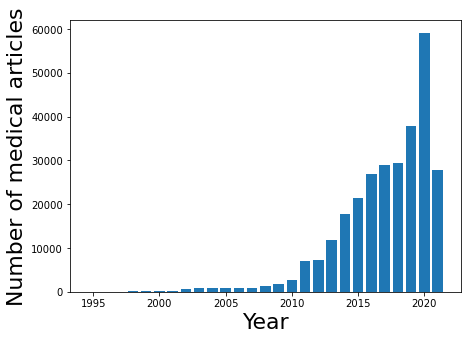

In [27]:
print('Number of English medical articles published in years 1995-(freeze time year):')
plt.rcParams['figure.figsize'] = 7, 5
font = {'size': 15} 
f = plt.figure()
plt.xlabel('Year', fontsize=22)
plt.ylabel('Number of medical articles', fontsize=22)
matplotlib.rc('font', **font)
plt.bar(years, n_articles_year)

In [28]:
entity = 'articles'

print('Number of medical English articles based on reliability of its source:')
for reliability,sources_id_en_medical_reliability in zip(['reliable', 'unknown', 'unreliable'], [sources_id_en_medical_reliable, sources_id_en_medical_unknown, sources_id_en_medical_unreliable]):
    sources_articles_n = 0
    for source_id in sources_id_en_medical_reliability:
        source_articles_n = get_data(entity, {'size': 1, 'sources': source_id}).json()['pagination']['total']
        sources_articles_n = sources_articles_n + source_articles_n
        
    print('Number of ' + str(reliability) + ' ' + str(entity) + ': ' + str(sources_articles_n))

Number of medical English articles based on reliability of its source:
Number of reliable articles: 110688
Number of unknown articles: 12381
Number of unreliable articles: 169786


### Claims

In [29]:
entity = 'claims'
print('Number of all ' + str(entity) + ': ' + str(get_data(entity, {'size': 1}).json()['pagination']['total']))

claims_medical_n = get_data(entity, {'size': 100, 'category': ['medical']}).json()['pagination']['total']
print('Number of medical ' + str(entity) + ': ' + str(claims_medical_n))

Number of all claims: 8866
Number of medical claims: 3052


In [30]:
df_fca_medical_bool = df_fact_checking_articles.category.apply(lambda x: 'medical' in x)
df_fact_checking_articles_medical = df_fact_checking_articles[df_fca_medical_bool]

In [31]:
print('Number of medical fact checking articles sources: ' + str(len(df_fact_checking_articles_medical.groupby(['source_id']))))
print('\n')

for source in df_fact_checking_articles_medical['source_id'].unique():    
    source_json = get_data('sources', {'ids': source}).json()['sources'][0]
    source_name = source_json.get('name', '')
    source_veracity = source_json.get('veracity')
    source_n_articles = len(df_fact_checking_articles_medical[df_fact_checking_articles_medical.source_id == source])
    
    print('Number of medical fact checking articles from source ' + str(source_name) + ': ' + str(source_n_articles))

Number of medical fact checking articles sources: 7


Number of medical fact checking articles from source factcheck.org: 26
Number of medical fact checking articles from source metafact.io: 505
Number of medical fact checking articles from source healthfeedback.org: 354
Number of medical fact checking articles from source fullfact.org: 754
Number of medical fact checking articles from source snopes.com: 714
Number of medical fact checking articles from source sciencefeedback.co: 3
Number of medical fact checking articles from source politifact.com: 1


In [32]:
ratings = []
n_claims_ratings = []
ratings_names_dict = {
    'null': 'Unknown',
    'unknown': 'Unknown',
    'false': 'False',
    'mostly-false': 'Mostly\nfalse',
    'mixture': 'Mixture',
    'mostly-true': 'Mostly\ntrue',
    'true': 'True'
}

entity = 'claims'
print('Number of medical ' + str(entity) + ': ' + str(get_data(entity, {'size': 1, 'category': ['medical']}).json()['pagination']['total']))
print('\n')

claims_medical_n_rating_unknown = claims_medical_n
for rating in ['false', 'mostly-false', 'mixture', 'mostly-true', 'true']:
    claims_medical_n_rating = get_data(entity, {'size': 1, 'category': ['medical'], 'rating': rating}).json()['pagination']['total']
    print('Number of medical ' + str(rating) + ' ' + str(entity) + ': ' + str(claims_medical_n_rating))
    print(f"Percentage of medical {str(rating)} {str(entity)}: {round((claims_medical_n_rating / claims_medical_n * 100), 2)} %\n")
    claims_medical_n_rating_unknown = claims_medical_n_rating_unknown - claims_medical_n_rating
    
    ratings.append(ratings_names_dict[rating])
    n_claims_ratings.append(claims_medical_n_rating)
    
    
rating = 'unknown'
print('Number of medical ' + str(rating) + ' ' + str(entity) + ': ' + str(claims_medical_n_rating_unknown))
print(f"Percentage of medical {str(rating)} {str(entity)}: {round((claims_medical_n_rating_unknown / claims_medical_n * 100), 2)} %\n")
ratings.append(rating)
n_claims_ratings.append(claims_medical_n_rating_unknown)

Number of medical claims: 3052


Number of medical false claims: 875
Percentage of medical false claims: 28.67 %

Number of medical mostly-false claims: 58
Percentage of medical mostly-false claims: 1.9 %

Number of medical mixture claims: 95
Percentage of medical mixture claims: 3.11 %

Number of medical mostly-true claims: 39
Percentage of medical mostly-true claims: 1.28 %

Number of medical true claims: 245
Percentage of medical true claims: 8.03 %

Number of medical unknown claims: 1740
Percentage of medical unknown claims: 57.01 %



Number of medical claims in our dataset per claim rating:


<BarContainer object of 6 artists>

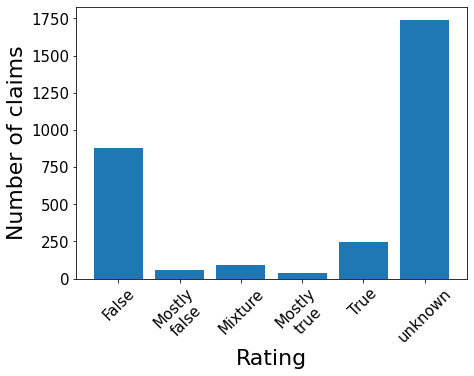

In [33]:
print('Number of medical claims in our dataset per claim rating:')
plt.rcParams['figure.figsize'] = 7, 5
font = {'size': 15} 
f = plt.figure()
plt.xlabel('Rating', fontsize=22)
plt.ylabel('Number of claims', fontsize=22)
matplotlib.rc('font', **font)
plt.xticks(rotation=45)
plt.bar(ratings, n_claims_ratings)

# 5.4.  Descriptive Analysis of Annotations Predicted by the Proposed Method

Besides raw data and manual labels, the introduced dataset also contains the predicted annotations (for claims presence, article stance and article-claim pair veracities).

In [35]:
entity = 'entity-annotations'
df_entity_annotations = get_entity_df(entity, {'entity_type': 'articles', 'method': 'Article veracity aggregation method'})

In [36]:
df_entity_annotations_vclaims = df_entity_annotations[df_entity_annotations['value.claims'].map(lambda d: len(d)) > 0]

In [37]:
sources_reliable_ids = df_sources[df_sources['veracity'] == 'reliable']['id'].tolist()
sources_unreliable_ids = df_sources[df_sources['veracity'] == 'unreliable']['id'].tolist()

articles_reliable_ids = list()
articles_unreliable_ids = list()

for source_id in sources_reliable_ids:
    article_ids = [0]
    while article_ids:
        article_ids = get_data('articles', {'id_only': 'yes', 'count': 1000, 'last_id': article_ids[-1], 'sources': source_id}).json()['ids']
        articles_reliable_ids.extend(article_ids)
    
for source_id in sources_unreliable_ids:
    article_ids = [0]
    while article_ids:
        article_ids = get_data('articles', {'id_only': 'yes', 'count': 1000, 'last_id': article_ids[-1], 'sources': source_id}).json()['ids']
        articles_unreliable_ids.extend(article_ids)

In [38]:
ac_pairs_present_yes = 0
ac_pairs_present_no = 0

claims_present_id = set()
claims_present_not_id = set()

veracity_set = {'false', 'mixture', 'mostly-false', 'mostly-true', 'true', 'unknown'}
claims_pveracity_n = dict()
for veracity in veracity_set:
    claims_pveracity_n[veracity] = 0
    
stance_set = {'contradicting', 'neutral', 'supporting'}
claims_stance_n = dict()
for stance in stance_set:
    claims_stance_n[stance] = 0
    
veracity_consistency_set = {'true', 'false', 'inconsistent'}
veracity_consistency_n = dict()
for veracity in veracity_consistency_set:
    veracity_consistency_n[veracity] = 0
    
veracity_binary_set = {' true', ' false', ''}
reliability_set = {'unreliable', 'reliable', 'unknown'}
veracity_reliability_n = dict()

for reliability in reliability_set:
    for veracity in veracity_binary_set:
        veracity_reliability_n[reliability + veracity] = 0


for index, row in df_entity_annotations_vclaims.iterrows():
    
    if int(row['entity_id']) in articles_reliable_ids:
        source_reliability = 'reliable' 
    elif int(row['entity_id']) in articles_unreliable_ids:
        source_reliability = 'unreliable'
    else:
        source_reliability = 'unknown'
    
    article_veracity_init = True
    veracity_consistent = True
    
    for claim in row['value.claims']:
        
        if claim['presence'] == 'yes':
            ac_pairs_present_yes = ac_pairs_present_yes + 1
            
            claims_present_id.add(claim['claim_id'])
            
            if claim['stance'] in claims_stance_n:
                claims_stance_n[claim['stance']] = claims_stance_n[claim['stance']] + 1
            else:
                claims_stance_n['neutral'] = claims_stance_n['neutral'] + 1
            
            claims_pveracity_n[claim['partial_veracity']] = claims_pveracity_n[claim['partial_veracity']] + 1
            veracity_reliability_n[source_reliability] = veracity_reliability_n[source_reliability] + 1
            
            if (claim['partial_veracity'] in {'false', 'mostly-false', 'mostly-true', 'true'}):
                if claim['partial_veracity'] in {'mostly-true', 'true'}:
                    claim_veracity = 'true'
                    veracity_reliability_n[source_reliability + ' ' + claim_veracity] = veracity_reliability_n[source_reliability +' '+ claim_veracity] + 1
                if claim['partial_veracity'] in {'false', 'mostly-false'}:
                    claim_veracity = 'false'
                    veracity_reliability_n[source_reliability + ' ' + claim_veracity] = veracity_reliability_n[source_reliability +' '+ claim_veracity] + 1
                    
                if article_veracity_init:
                    article_veracity = claim_veracity
                    article_veracity_init = False
                    
                if article_veracity != claim_veracity:
                    veracity_consistent = False

    if article_veracity_init == False:
            if veracity_consistent:
                veracity_consistency_n[article_veracity] = veracity_consistency_n[article_veracity] + 1
            else:
                veracity_consistency_n['inconsistent'] = veracity_consistency_n['inconsistent'] + 1

ac_pairs_present_all = get_data('relation-annotations', {'size': 1, 'source_entity_type': 'articles', 'method': 'Claim-presence detection method (IR and NN approach)'}).json()['pagination']['total']
ac_pairs_present_no = ac_pairs_present_all - ac_pairs_present_yes

print('Number of not present article-claim mappings: ' + str(ac_pairs_present_no))
print('Number of present article-claim mappings: ' + str(ac_pairs_present_yes))

print('\n')

print('Number of unique mapped articles: ' + str(len(df_entity_annotations_vclaims)))
print(f"Percentage of unique mapped articles : {round((len(df_entity_annotations_vclaims) / get_data('articles', {'size': 1, 'monitoring_tags': ['medical', 'english']}).json()['pagination']['total'] * 100), 2)} %\n")

print('\n')

print('Number of unique mapped claims: ' + str(len(claims_present_id)))
print(f"Percentage of unique mapped claims: {round((len(claims_present_id) / get_data('claims', {'size': 1, 'category': ['medical']}).json()['pagination']['total'] * 100), 2)} %\n")

print('\n')

print('Number of present mapped claims with stance: ' + str(ac_pairs_present_yes))
for stance,number in claims_stance_n.items():
    print('Number of present mapped claims with ' + str(stance) + ' stance: ' + str(number))
    print(f"Percentage of present mapped claims with {str(stance)} stance: {round((number / ac_pairs_present_yes * 100), 2)} %\n")
print('\n')

print('Number of present mapped claims with partial veracity: ' + str(ac_pairs_present_yes))                                                                              
for veracity,number in claims_pveracity_n.items():
    print('Number of present mapped claims with ' + str(veracity) + ' stance: ' + str(number))
    print(f"Percentage of present mapped claims with {str(veracity)} stance: {round((number / ac_pairs_present_yes * 100), 2)} %\n")
    
print('\n')
                                                                            
for veracity,number in veracity_consistency_n.items():
    print('Number of mapped articles witch veracity consistancy status ' + str(veracity) + ': ' + str(number))
    print(f"Percentage of mapped articles witch veracity consistancy status {str(veracity)}: {round((number / len(df_entity_annotations_vclaims) * 100), 2)} %\n")
    
print('\n')
       
for rating,number in veracity_reliability_n.items():
    if rating in ['unreliable', 'reliable', 'unknown']:
        print('Number of present claim article pairs - ' + str(rating) + ' sources: ' + str(number))
        print(f"Percentage of present claim article pairs - {str(rating)} sources: {round((number / ac_pairs_present_yes * 100), 2)} %\n")
    else:
        reliability = rating.split()[0]
        veracity = rating.split()[1]
        print('Number of present claim article pairs - ' + str(veracity) + ' veracity from ' + str(reliability) + ' source: ' + str(number))
        print(f"Percentage of present claim article pairs from {str(reliability)} sources - {str(veracity)} veracity from {str(reliability)} source: {round((number / veracity_reliability_n[reliability] * 100), 2)} %\n")

Number of not present article-claim mappings: 293395
Number of present article-claim mappings: 44253


Number of unique mapped articles: 31683
Percentage of unique mapped articles : 10.82 %



Number of unique mapped claims: 1097
Percentage of unique mapped claims: 35.94 %



Number of present mapped claims with stance: 44253
Number of present mapped claims with contradicting stance: 7281
Percentage of present mapped claims with contradicting stance: 16.45 %

Number of present mapped claims with neutral stance: 1698
Percentage of present mapped claims with neutral stance: 3.84 %

Number of present mapped claims with supporting stance: 35274
Percentage of present mapped claims with supporting stance: 79.71 %



Number of present mapped claims with partial veracity: 44253
Number of present mapped claims with true stance: 7827
Percentage of present mapped claims with true stance: 17.69 %

Number of present mapped claims with unknown stance: 26972
Percentage of present mapped claims with u

In [48]:
claims_source_names = dict()
claims_sources_names_set = set()

for claim_id in claims_present_id:
    fcas = get_data('relation-annotations', {'target_entity_type': 'claims', 'target_entity_id': claim_id, 'source_entity_type': 'fact_checking_articles'}).json()
    
    if fcas['pagination']['total'] > 0:
        fca_id = fcas['relation_annotations'][0]['source_entity_id']
        source_name = get_data('fact-checking-articles/' + str(fca_id), {}).json()['source']['name']

        claims_source_names[claim_id] = source_name
        claims_sources_names_set.add(source_name)
    else:
        claims_source_names[claim_id] = 'unknown'
        claims_sources_names_set.add('unknown')

In [49]:
claims_source_names_n = dict()
for source_name in claims_sources_names_set:
    claims_source_names_n[source_name] = 0
claims_source_names_n['Ghenai 2018'] = 0

for index, row in df_entity_annotations_vclaims.iterrows():
    for claim in row['value.claims']:
        if claim['claim_id'] in range(5300, 5431, 1):
            source_name = 'Ghenai 2018'
        else:
            source_name = claims_source_names[claim['claim_id']]
        claims_source_names_n[source_name] = claims_source_names_n[source_name] + 1

In [50]:
for source_name,number in claims_source_names_n.items():
    print('Number of present mapped article-claim pairs - claims from source '+ str(source_name) + ': ' + str(number))
    print(f"Percentage of present mapped article-claim pairs - claims from source {str(source_name)}: {round((number / ac_pairs_present_yes * 100), 2)} %\n")

Number of present mapped article-claim pairs - claims from source sciencefeedback.co: 6
Percentage of present mapped article-claim pairs - claims from source sciencefeedback.co: 0.01 %

Number of present mapped article-claim pairs - claims from source fullfact.org: 5858
Percentage of present mapped article-claim pairs - claims from source fullfact.org: 13.24 %

Number of present mapped article-claim pairs - claims from source unknown: 16
Percentage of present mapped article-claim pairs - claims from source unknown: 0.04 %

Number of present mapped article-claim pairs - claims from source snopes.com: 617
Percentage of present mapped article-claim pairs - claims from source snopes.com: 1.39 %

Number of present mapped article-claim pairs - claims from source metafact.io: 32019
Percentage of present mapped article-claim pairs - claims from source metafact.io: 72.35 %

Number of present mapped article-claim pairs - claims from source healthfeedback.org: 3866
Percentage of present mapped ar